# HW 3: Minisum Location (Solution)
---
`ISE 754, Fall 2024`

__Assigned:__ Mon, 9 Sep (Individual Assignment)  
__Due:__ 10:00a, Mon, 16 Sep  

Use the Code cells in this Jupyter Notebook to answer the following questions. Please run all of the cells in your notebook and then submit it as a .ipynb file, along with a .html or .pdf copy, via Moodle. (There is a _Run All Cells_ command under the _Run_ menu.)

---

__(1)__ Referring to all of cities in North Carolina and South Carolina with populations of at least 10,000:

(a)	Assuming weight is proportional to population, what location minimizes the sum of the weight times the great-circle distance to each city?

In [1]:
using Logjam.DataTools, Logjam.MapTools
using GeoMakie, DataFrames
using Optim, Statistics

function dgc(xy₁, xy₂; unit=:mi)
    length(xy₁) == length(xy₂) == 2 || error("Inputs must have length 2.")
    unit in [:mi, :km] || error("Unit must be :mi or :km")

    Δx, Δy = xy₂[1] - xy₁[1], xy₂[2] - xy₁[2]
    a = sind(Δy / 2)^2 + cosd(xy₁[2]) * cosd(xy₂[2]) * sind(Δx / 2)^2
    2 * asin(min(sqrt(a), 1.0)) * (unit == :mi ? 3958.75 : 6371.00)
end

Dgc(X₁, X₂) = [dgc(i, j) for i in eachrow(X₁), j in eachrow(X₂)]

df = filter!(r -> any(i -> r.STFIP == i, st2fips.([:NC,:SC])) && r.POP > 10_000, usplace())
P = hcat(df.LON, df.LAT)
TC(xy) = sum(df.POP .* Dgc(xy, P))
xyᵒ = optimize(TC, mean(P, dims=1)).minimizer

1×2 Matrix{Float64}:
 -80.4796  35.1

(b)	What city is closest to the optimal location?

In [2]:
d = Dgc(xyᵒ, P)[:]   # Using [:] to convert 1 x n matrix to n-vector
idx = argmin(d)
println(df.NAME[idx], ", ", df.ST[idx])

Monroe, NC


(c)	What city is furthest from the location?

In [3]:
idx = argmax(d)
println(df.NAME[idx], ", ", df.ST[idx])

Elizabeth City, NC


(d)	What are the four closest cities to the location?

In [4]:
idx = sortperm(d)[1:4]
[println(df.NAME[i], ", ", df.ST[i]) for i in idx];

Monroe, NC
Indian Trail, NC
Stallings, NC
Mint Hill, NC


(e)	Plot the name and location of the four closest cites.

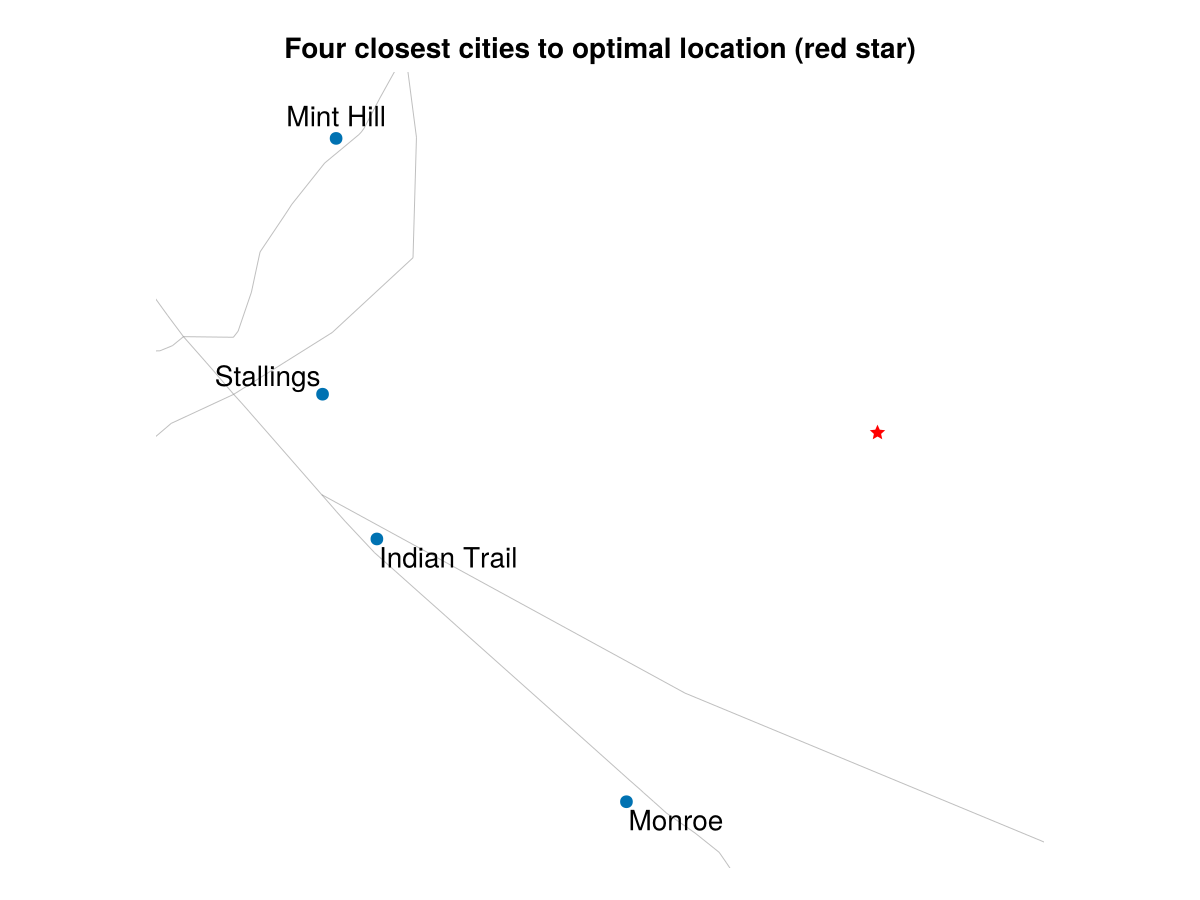

In [5]:
x, y = df.LON[idx], df.LAT[idx]
fig, ax = makemap([x; xyᵒ[1]], [y; xyᵒ[2]])
scatter!(ax, xyᵒ...; color = :red, marker = :star5)
scatter!(ax, x, y)
text!(ax, x, y, text=df.NAME[idx]; aligntext(x, y)...)
ax.title = "Four closest cities to optimal location (red star)"
fig

(f)	How far is the location from the largest (greatest population) city?

In [6]:
idx = argmax(df.POP)
println(dgc(xyᵒ, P[idx, :]), " miles from ", df.NAME[idx], ", ", df.ST[idx])

21.228492698601023 miles from Charlotte, NC


(g)	What city with a population of at least 40,000 is closest to the location?

In [7]:
idx2 = findall(df.POP .>= 40_000)
idx = idx2[argmin(d[idx2])]                  # Taking index of index to ref original df
println(df.NAME[idx], ", ", df.ST[idx])

Charlotte, NC


(h)	What percentage of the population in the cities is South of the location?

In [8]:
100 * sum(df.POP[df.LAT .< xyᵒ[2]])/sum(df.POP)

35.60987364507298

(i)	What is the total population of all of the cities that are within 80 miles of the location?

In [9]:
sum(df.POP[d .<= 80])

2934157

(j)	Plot the name and location of the six closest cities to the optimal location that have a population of at least 40,000.

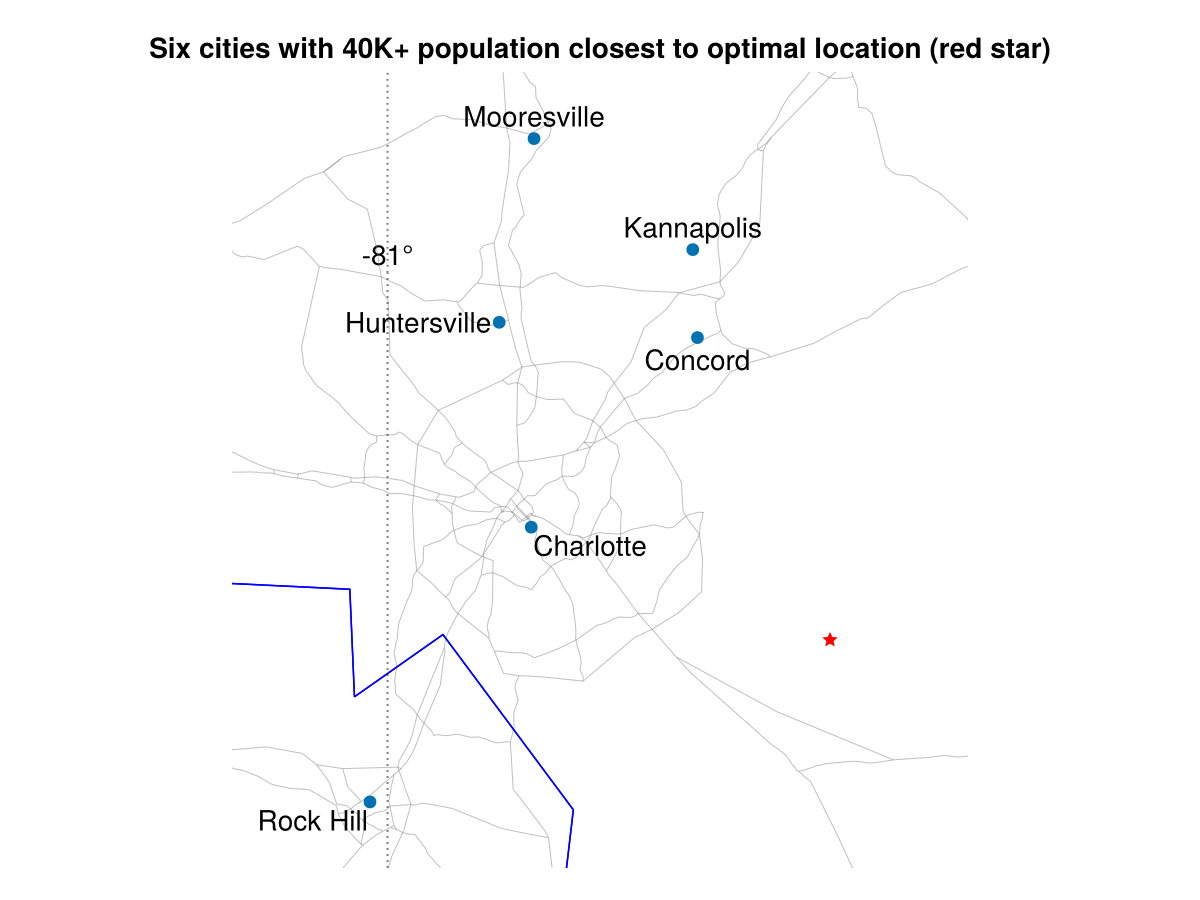

In [10]:
idx2 = findall(df.POP .>= 40_000)
idx = idx2[sortperm(d[idx2])[1:6]]
x, y = df.LON[idx], df.LAT[idx]
fig, ax = makemap([x; xyᵒ[1]], [y; xyᵒ[2]])
scatter!(ax, xyᵒ...; color = :red, marker = :star5)
scatter!(ax, x, y)
text!(ax, x, y, text=df.NAME[idx]; aligntext(x, y)...)
ax.title = "Six cities with 40K+ population closest to optimal location (red star)"
fig

(k)	Assuming that three DCs are located in Raleigh, NC, Charlotte, NC, and North Charleston, SC, respectively, and that each city is served by its closest DC, what is the total population served by each DC

In [11]:
using SparseArrays

function name2lonlat(namein, df)   # Added "City, ST" option
    name = split(namein, ", ")
    if length(name) == 1
        idx = findfirst(r -> r.NAME == name[1], eachrow(df))   # Find first match
    elseif length(name) == 2
        idx = findfirst(r -> r.NAME == name[1] && r.ST == name[2], eachrow(df))
    end
    if idx === nothing
        error("'$namein' not found in $df")
    end
    return collect(df[idx, [:LON, :LAT]])
end

name = ["Raleigh", "Charlotte", "North Charleston"]
X = vcat([name2lonlat(x, df)' for x in name]...)
D = Dgc(X, P)
n, m = size(D)
W = sparse([argmin(c) for c in eachcol(D)], 1:m, df.POP, n, m)
pop = sum(W, dims=2)[:]
[println(i, " people served by ", j) for (i,j) in zip(pop, name)];

2739349 people served by Raleigh
3247684 people served by Charlotte
922472 people served by North Charleston


---
__(2)__ Assume that 28, 48, and 32 full truckloads (TL) per year of finished goods will be shipped to customers located in Detroit, MI, Gainesville, FL, and Memphis, TN.

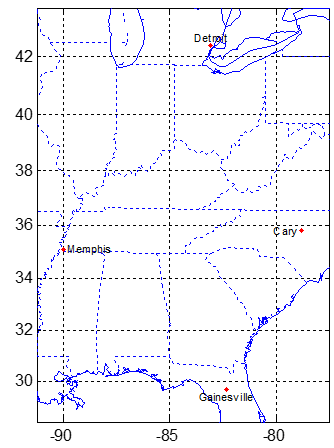

(a) Where (in decimal degrees) should a new factory be located in order to minimize total outbound truck travel?

In [12]:
using Optim, Statistics

f = [28, 48, 32]
name = ["Detroit, MI", "Gainesville, FL", "Memphis, TN"]
P = vcat([name2lonlat(x, usplace())' for x in name]...)

3×2 Matrix{Float64}:
 -83.1022  42.383
 -82.3492  29.6807
 -89.9666  35.109

In [13]:
TD(xy) = sum(f[:]' .* Dgc(xy, P))
res = optimize(TD, mean(P, dims=1))
TDᵒ = res.minimum
xyᵒ = res.minimizer

1×2 Matrix{Float64}:
 -84.8996  33.3287

(b) Near what city with a population of at least 50,000 is this location?

In [14]:
function lonlat2name(D, name, st)
    for i = 1:size(D, 1)
        d = D[i, :]
        println("NF", i, ": ", round(minimum(d)), " miles from ", 
            name[argmin(d)], ", ", st[argmin(d)])
    end
end

df = filter(r -> r.POP >= 50_000, usplace())
lonlat2name(Dgc(xyᵒ, hcat(df.LON, df.LAT)), df.NAME, df.ST)

NF1: 30.0 miles from South Fulton, GA


(c) Near what city with a population of at least 10,000 is this location?

In [15]:
df = filter(r -> r.POP >= 10_000, usplace())
lonlat2name(Dgc(xyᵒ, hcat(df.LON, df.LAT)), df.NAME, df.ST)

NF1: 8.0 miles from Newnan, GA


(d) A circuity factor is the average ratio of the actual road distance between two points and the great circle distance between the two points. Use the simple average of the distances between all pairs of customers (three values, in total) to estimate the circuity factor. You can use _Google Maps_ to determine the actual road distances (where you can pick the fastest route if several routes are available).

In [16]:
D = Dgc(P,P)
g = mean([1057/D[1,2], 754/D[1,3], 719/D[2,3]])   # Using fastest rte per Gmap

1.216453134500423

(e) If the transportation rate is $2.00 per mile for each one-way TL shipment, what is the total transportation cost per year assuming that the trucks do not return to the factory and that the actual road distances are estimated using a circuity factor?

In [17]:
r = 2.00
TCᵒ = g * TDᵒ * r

101880.84805911437

(f) Assuming that the factory will be built in Cary, NC instead of at the optimal location, what is the increase in total transportation cost per year?

In [18]:
xyCary = name2lonlat("Cary, NC", usplace())
TCcary = g * TD(xyCary') * r

138471.21439087007

In [19]:
println("Increase = \$", round((TCcary - TCᵒ), digits=2), " per year")

Increase = $36590.37 per year
